In [1]:
import sys
try:
    sys.path.remove('/home/adun6414/JModelica/v2_0/JModelica/Python')
    sys.path.append('/home/adun6414/Downloads/PyFMI') # !!!!
except:
    print(sys.path)
    
import pyfmi
from pandas import *
from H_utility import *
import numpy as np
from numpy import *
import matplotlib.pyplot as mp
import time
from scipy.linalg import block_diag
import scipy as sp
from H_blkdiag import H_blkdiag
import PnP_subfunc
from PnP_subfunc import H_vec
import scipy as sp
import scipy.interpolate
import control.matlab as ctool
from H_simobj import H_simobj
import os

/home/adun6414/Work/CERC_UCM/H_simobj.py:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res0=obj.fmuinpy.simulate(start_time=obj.t_schedule[0],final_time=obj.t_schedule[-1], options=obj._sim_opts, input=IN)
Could not find GLIMDA.
/home/adun6414/Downloads/anaconda3/lib/python3.7/site-packages/pyfmi/fmi_algorithm_drivers.py:329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self.model.setup_experiment(tolerance=rtol, start_time=self.start_time, stop_time=self.final_time)


Final Run Statistics: --- 

 Number of steps                                 : 2286
 Number of function evaluations                  : 3631
 Number of Jacobian evaluations                  : 96
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 204
 Number of nonlinear iterations                  : 3406
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 2904
 Number of state events                          : 56

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18316800.0 - 18572400.0 seconds.
Elapsed simulation time: 0.36136005399

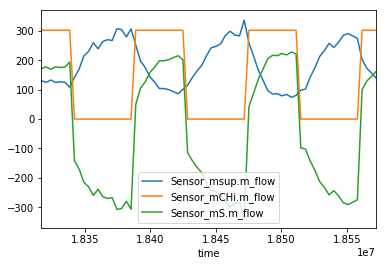

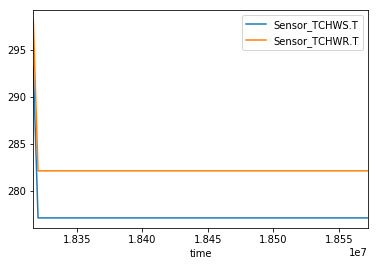

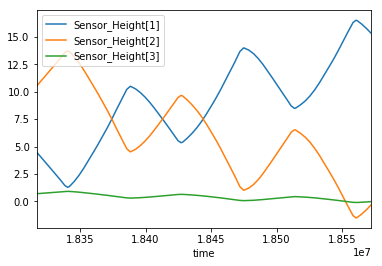

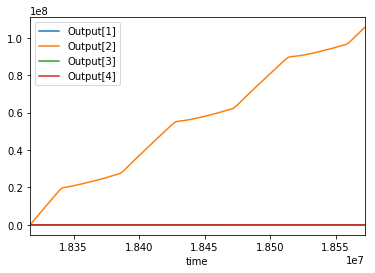

In [2]:

currentdir='/home/adun6414/Work/CERC_UCM'
os.chdir(currentdir)


# configuration
dt=60*60; # 60 min sampling time
start_time=H_date2simtime(to_datetime('2018-08-01 00:00'),'2018')
final_time=H_date2simtime(to_datetime('2018-08-03 23:50'),'2018')
simtimes=arange(start_time,final_time,dt)
simtimedate=date_range(start=H_simtime2date(start_time,'2018'),end=H_simtime2date(final_time,'2018'),freq=str(int(dt*1./60))+'T')

key_x='H_par_x0'
x0_val=0.7; # initial state of charge
# inputs (controllable variables)
key_u=['ChillerON','SP_mCH', 'TCHeSP']
# inputs: disturbance
key_w=['BuildingCoolingLoads', 'ER', 'PnonHVAC', 'Psolarpv']
# outputs of interests
key_y=['Output[1]','Output[2]','Output[3]','Output[4]','Sensor_TCHWS.T','Sensor_TCHWR.T','Sensor_msup.m_flow','Sensor_mCHi.m_flow','Sensor_mS.m_flow','time',
      'Sensor_Tstorage[1].y','Sensor_Tstorage[2].y','Sensor_Height[1]','Sensor_Height[2]','Sensor_Height[3]']

testcase=2
if testcase==1:
    modelname='Merced.CoolingPlantNew.Chiller_Storage_Only_V2_MPC'
    modelicafile='/home/adun6414/Work/CERC_UCM/Merced/CoolingPlantNew/Chiller_Storage_Only_V2_MPC.mo'
elif testcase==2:
    modelname='Merced.CoolingPlantNew.Chiller_Storage_CoolingTower_V2_MPC'
    modelicafile='/home/adun6414/Work/CERC_UCM/Merced/CoolingPlantNew/Chiller_Storage_CoolingTower_V2_MPC.mo'

idmodel=('CASE900Load1576283834') # not used for UC-Merced

obj=H_simobj(dt=dt,start_time=start_time,final_time=final_time,modelname=modelname,modelicafile=modelicafile,
             fmu='./Merced_CoolingPlantNew_Chiller_Storage_CoolingTower_V2_MPC.fmu',
             idmodel=idmodel,key_u=key_u,key_w=key_w,key_y=key_y,key_x=key_x)
             
#% data loading and resampling
os.chdir('/home/adun6414/Work/CERC_UCM/Fig_n_data')
filename='DATA8to8.csv' #filename='DATA8to9.csv'
DATARAW=read_csv(filename).set_index('Date')
DATARAW=DATARAW.set_index(to_datetime(DATARAW.index)) # change 'str' to datetime obj
DATARAW['time']=H_date2simtime(DATARAW.index,'2018')
dummy=DATARAW.reindex(simtimedate,method='nearest') # resample or reindex
DATA=dummy[['time','QBL','Twb','QCHLsum']].fillna(method='ffill')
DATA['Pow']=dummy[['PCHsum','PCTtot']].sum(axis=1)
del DATARAW, dummy
os.chdir(currentdir)

#% specify disturbances
t_schedule=simtimes

CHON=H_schedule(t_schedule,array([7,19]),1,1)
mEva_flow_nominal=obj.fmuinpy.get('mEva_flow_nominal')
SP_mCH=H_schedule(t_schedule,array([7,19]),0.*mEva_flow_nominal,0.9*mEva_flow_nominal)
TCHeSP=H_schedule(t_schedule,array([7,19]),4,4) # C
QBL=H_iscolumn(DATA['QBL'].to_numpy()) # kW
ER=H_schedule(t_schedule,array([7,19]),2,1) #$/kWh
PnonHVAC=H_schedule(t_schedule,[7,19],0*1000,0*1000) # kW
Psolarpv=H_schedule(t_schedule,[7,19],0*500,0) # kW
          
u=hstack((CHON,SP_mCH,TCHeSP))
w=hstack((QBL,ER,PnonHVAC,Psolarpv))

schedule={'u': u, 'w': w, 't': H_iscolumn(t_schedule)}
# conventional control simulation
(res,IN0)=obj.simulate_schedule(x0_val,schedule,wannaplot=True)

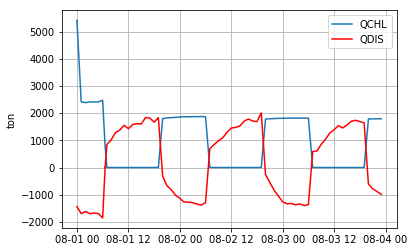

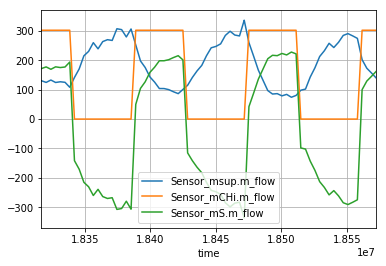

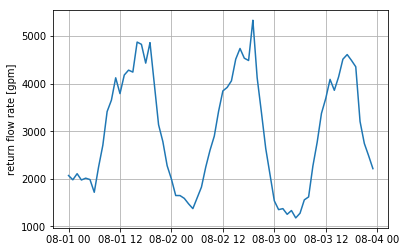

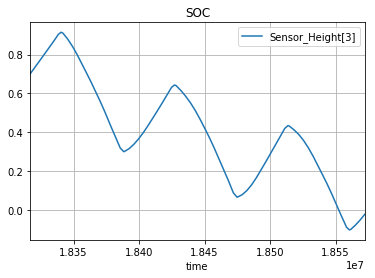

In [3]:
data=DataFrame(columns=obj.key_u+obj.key_y+obj.key_w)  
for k in obj.key_u+obj.key_y+obj.key_w:
    data[k]=res[k]
data.index=data.time
figure(100)
plot(to_datetime(H_simtime2date(data['time'],'2018')),kW2ton(data['Output[3]']))     
plot(to_datetime(H_simtime2date(data['time'],'2018')),kW2ton(data['Output[4]']),'r')
legend(['QCHL','QDIS'])
ylabel('ton')
grid(True)

data.plot(x='time',y=[k for k in obj.key_y if '.m_flow' in k])
grid(True)

figure(102)
plot(to_datetime(H_simtime2date(data['time'],'2018')),data['Sensor_msup.m_flow'].apply(kgs2gpm))
ylabel('return flow rate [gpm]')
grid(True)

data.plot(x='time',y=[k for k in obj.key_y if 'Height[3]' in k])    
title('SOC')
grid(True)


Np: 48 W: (48, 4)
In Bellam,  Np: 48 W: (48, 4)
(48, 1)
13286.587062725364
(48, 1)
13286.587062725364


/home/adun6414/Downloads/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Final Run Statistics: --- e+07

 Number of steps                                 : 96485
 Number of function evaluations                  : 150238
 Number of Jacobian evaluations                  : 3323
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 7009
 Number of nonlinear iterations                  : 137508
 Number of nonlinear convergence failures        : 7
 Number of state function evaluations            : 120253
 Number of state events                          : 3182

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18316800.0 - 18486000.0 seconds.
Elapsed simulation tim

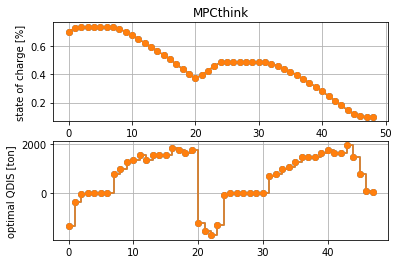

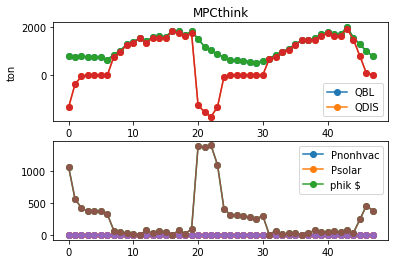

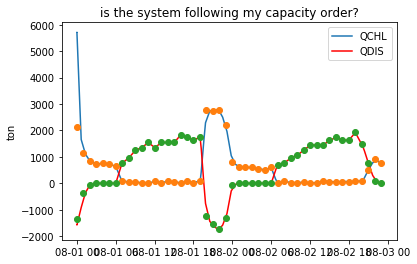

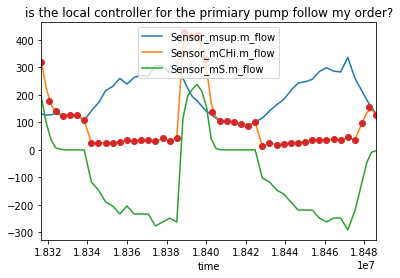

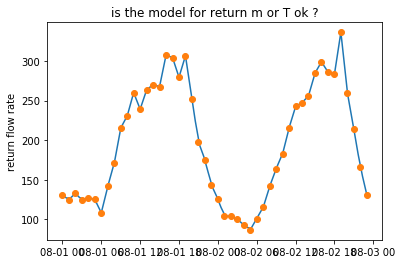

<Figure size 432x288 with 0 Axes>

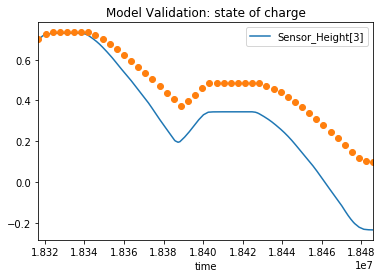

<Figure size 432x288 with 0 Axes>

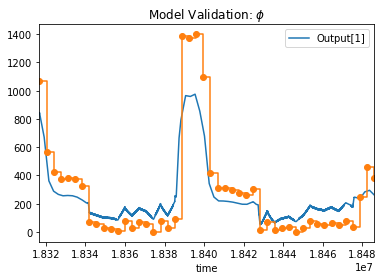

In [4]:
from H_DP_Merced_Simple import H_DP_Merced_Simple

#obj.getidmodel(idmodel='CASE900Load1576283834') # unused in DP
obj.MPCsetup(MPCobj=H_DP_Merced_Simple,Npday=2) 
#Q: sampling time of simluation output is the same as control implementation period?
obj.does_local_follow_mpc(x0_val)

Np adjusted: 48
in adjustNp adjusted W: (48, 4) orginal W (48, 4)
Np: 48 W: (48, 4)
In Bellam,  Np: 48 W: (48, 4)
(48, 1)
13286.587062725364
13286.587062725364
        cur_t          Uop         x          phi
0  18316800.0 -4753.996320  0.700000  1070.566177
1  18316800.0 -1348.183638  0.726056   567.056700
2  18316800.0  -178.389942  0.733446   424.230624
Final Run Statistics: --- 

 Number of steps                                 : 234
 Number of function evaluations                  : 286
 Number of Jacobian evaluations                  : 6
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 3
 Number of nonlinear iterations                  : 276
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 247
 Number of state events                          : 2

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear 

(41, 1)
9768.218724968274
9768.218724968274
        cur_t          Uop         x        phi
0  18342000.0  2716.720048  0.734484  73.464958
1  18342000.0  3395.812139  0.719593  53.739124
2  18342000.0  4414.450275  0.700981  30.540980
Final Run Statistics: --- 

 Number of steps                                 : 2757
 Number of function evaluations                  : 4205
 Number of Jacobian evaluations                  : 94
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 169
 Number of nonlinear iterations                  : 3833
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 3448
 Number of state events                          : 92

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e

(35, 1)
11323.641176623489
11323.641176623489
        cur_t          Uop         x        phi
0  18363600.0  5433.088411  0.524994  30.299949
1  18363600.0  5433.088411  0.495216  69.074216
2  18363600.0  5433.088411  0.465437  53.686719
Final Run Statistics: --- 

 Number of steps                                 : 4129
 Number of function evaluations                  : 6426
 Number of Jacobian evaluations                  : 139
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 321
 Number of nonlinear iterations                  : 5870
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 5212
 Number of state events                          : 138

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06

(29, 1)
13538.301794595036
13538.301794595036
        cur_t          Uop         x          phi
0  18385200.0  6112.180501  0.240095    93.746799
1  18385200.0 -4414.450275  0.206594  1388.018917
2  18385200.0 -5433.088411  0.230790  1369.830319
Final Run Statistics: --- 

 Number of steps                                 : 2513
 Number of function evaluations                  : 3871
 Number of Jacobian evaluations                  : 78
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 179
 Number of nonlinear iterations                  : 3559
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 3113
 Number of state events                          : 77

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 

(46, 1)
16180.078519842536
16180.078519842536
        cur_t          Uop         x          phi
0  18410400.0 -7470.364683  0.474303  1378.933600
1  18410400.0 -7470.364683  0.515248  1367.793617
2  18410400.0 -7809.910728  0.556192  1394.533165
Final Run Statistics: --- 

 Number of steps                                 : 74
 Number of function evaluations                  : 78
 Number of Jacobian evaluations                  : 2
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 74
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 75

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1

(39, 1)
8942.250798170777
8942.250798170777
        cur_t          Uop         x        phi
0  18435600.0  3395.812139  0.665061  13.586435
1  18435600.0  3735.358184  0.646448  29.314264
2  18435600.0  4414.450275  0.625975  32.470050
Final Run Statistics: --- 

 Number of steps                                 : 2906
 Number of function evaluations                  : 4478
 Number of Jacobian evaluations                  : 116
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 209
 Number of nonlinear iterations                  : 4102
 Number of nonlinear convergence failures        : 1
 Number of state function evaluations            : 3616
 Number of state events                          : 93

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.

(33, 1)
10675.659269034111
10675.659269034111
        cur_t          Uop         x        phi
0  18457200.0  5772.634456  0.444399  59.298839
1  18457200.0  6112.180501  0.412760  47.526138
2  18457200.0  5772.634456  0.379260  67.288036
Final Run Statistics: --- 

 Number of steps                                 : 4341
 Number of function evaluations                  : 6750
 Number of Jacobian evaluations                  : 149
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 312
 Number of nonlinear iterations                  : 6154
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 5460
 Number of state events                          : 148

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06

(26, 1)
9294.271288878184
9294.271288878184
        cur_t          Uop         x          phi
0  18482400.0 -6112.180501  0.265641  1372.191335
1  18482400.0 -6791.272592  0.299141  1363.988459
2  18482400.0 -7809.910728  0.336364  1406.539930
Final Run Statistics: --- 

 Number of steps                                 : 93
 Number of function evaluations                  : 101
 Number of Jacobian evaluations                  : 2
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 97
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 94

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.

(43, 1)
9932.604821421237
9932.604821421237
        cur_t          Uop         x         phi
0  18507600.0    14.245210  0.541669  220.775408
1  18507600.0    10.400156  0.541590  239.994839
2  18507600.0  2037.627957  0.541533    7.133092
Final Run Statistics: --- 

 Number of steps                                 : 80
 Number of function evaluations                  : 86
 Number of Jacobian evaluations                  : 2
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 82
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 81

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 

Final Run Statistics: --- 

 Number of steps                                 : 3280
 Number of function evaluations                  : 5163
 Number of Jacobian evaluations                  : 132
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 251
 Number of nonlinear iterations                  : 4719
 Number of nonlinear convergence failures        : 1
 Number of state function evaluations            : 4099
 Number of state events                          : 110

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18529200.0 - 18532800.0 seconds.
Elapsed simulation time: 0.524689087

Final Run Statistics: --- 

 Number of steps                                 : 2449
 Number of function evaluations                  : 3736
 Number of Jacobian evaluations                  : 75
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 169
 Number of nonlinear iterations                  : 3436
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 3054
 Number of state events                          : 74

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18550800.0 - 18554400.0 seconds.
Elapsed simulation time: 0.36749891300

CVodeError: 'The right-hand side function failed at the first call. At time 18561600.000000.'

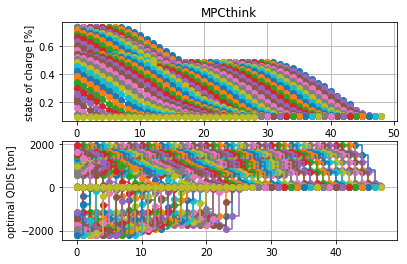

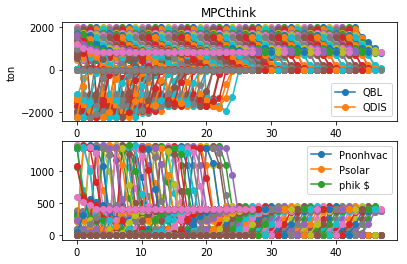

In [5]:
#%% MPC evaulation inputs: starts, final time, IC
obj.evaluate_mpc(x0_val)

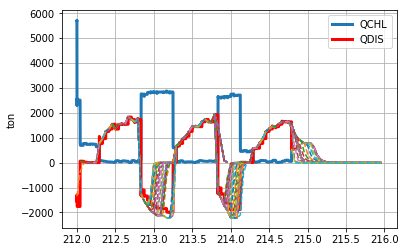

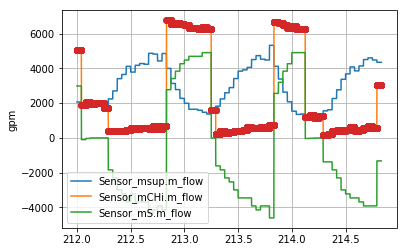

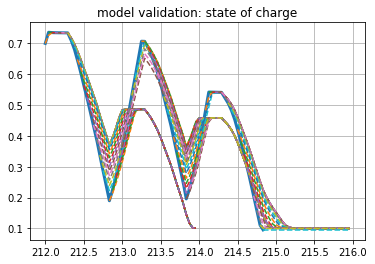

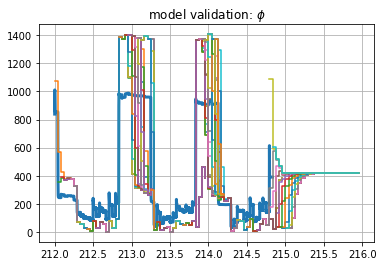

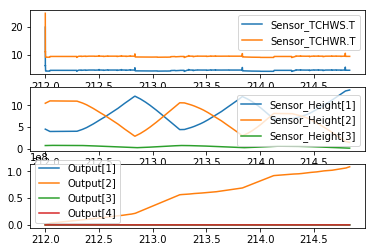

In [6]:
obj.analysis_performance()